# Coffea-Casa Processor-Based Workflow Test

This notebook demonstrates the UnifiedProcessor workflow with coffea.processor.Runner on Coffea-Casa, including skimming, analysis, histogramming, and statistics steps.

## Workflow Overview

1. Setup Python path for intccms package
2. Install dependencies and register modules for cloud pickle
3. Acquire Dask client from Coffea-Casa environment
4. Configure analysis parameters
5. Run metadata extraction
6. Initialize UnifiedProcessor
7. Run processor with coffea.processor.Runner
8. Save histograms
9. Run statistical analysis (if enabled)

In [1]:
# Setup Python path to include intccms package
import sys
import time
from pathlib import Path

# Add src directory to Python path
repo_root = Path.cwd()
src_dir = repo_root / "src"
examples_dir = repo_root
if str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))
if str(examples_dir) not in sys.path:
    sys.path.insert(0, str(examples_dir))
print(f"✅ Added {src_dir} to Python path")
print(f"✅ Added {examples_dir} to Python path")

✅ Added /home/cms-jovyan/intccms-agc-demo-10/src to Python path
✅ Added /home/cms-jovyan/intccms-agc-demo-10 to Python path


In [2]:
COFFEA_VERSION = "2025.10.3.dev17+g2cde65fb6" # 2025.10.2
COFFEA_PIP = "git+https://github.com/scikit-hep/coffea@master"
try:
    import omegaconf
except ImportError:
    print("⚠️ omegaconf not found, installing...")
    ! pip install omegaconf

try:
    import coffea
    print("Coffea version: ", coffea.__version__)
    assert coffea.__version__ == "2025.10.3.dev9+g41c84f7a9"
except (ImportError, AssertionError):
    print("⚠️ coffea not found or incorrect version, installing...")
    ! pip install $COFFEA_PIP
print("✅ All dependencies are installed.")

Coffea version:  2025.10.3.dev9+g41c84f7a9
✅ All dependencies are installed.


In [3]:
# Imports and cloudpickle registration
import copy
import os

os.environ['AWS_ACCESS_KEY_ID'] = ""
os.environ['AWS_SECRET_ACCESS_KEY'] = ""

from dask.distributed import Client, PipInstall
from coffea.processor import DaskExecutor
from coffea.nanoevents import NanoAODSchema

import cloudpickle
import intccms
import example_cms

# Register modules for cloud pickle
cloudpickle.register_pickle_by_value(intccms)
cloudpickle.register_pickle_by_value(example_cms)

from example_cms.configs.configuration import config as original_config
from intccms.schema import Config, load_config_with_restricted_cli
from intccms.utils.output import OutputDirectoryManager
from intccms.metadata_extractor import DatasetMetadataManager
from intccms.datasets import DatasetManager
from intccms.analysis import run_processor_workflow

## Acquire Dask Client

Coffea-Casa provides a shared scheduler. Connect to it and register dependencies.

In [4]:
def acquire_client():
    """Acquire Dask client from Coffea-Casa environment."""
    client = Client("tls://localhost:8786")
    dependencies = [COFFEA_PIP] #["coffea==2025.10.2"]
    client.register_plugin(PipInstall(packages=dependencies))
    cluster = None  # no local cluster in this mode
    return client, cluster

## Configuration Setup

Configure analysis parameters including which processes to run and output settings.

In [7]:
# Configuration setup
config = copy.deepcopy(original_config)

# Limit files for testing
config["datasets"]["max_files"] = None

# Use local output directory
config["general"]["output_dir"] = "example_cms/outputs/"

# Configuration flags
config["general"]["read_from_cache"] = False
config["general"]["run_metadata_generation"] = False
config["general"]["run_processor"] = False  # Set to False to skip processor and load saved histograms
config["general"]["save_skimmed_output"] = False  # Set to True to save filtered events to disk
config["general"]["run_analysis"] = True
config["general"]["run_histogramming"] = True
config["general"]["run_systematics"] = True
config["general"]["run_statistics"] = True

# Test only signal dataset
#config["general"]["processes"] = ["data"]

cli_args = []
full_config = load_config_with_restricted_cli(config, cli_args)
validated_config = Config(**full_config)

print(f"✅ Configuration loaded with max_files={validated_config.datasets.max_files}")
print(f"   - run_processor: {validated_config.general.run_processor}")
print(f"   - save_skimmed_output: {validated_config.general.save_skimmed_output}")
print(f"   - run_analysis: {validated_config.general.run_analysis}")
print(f"   - run_histogramming: {validated_config.general.run_histogramming}")
print(f"   - run_systematics: {validated_config.general.run_systematics}")
print(f"   - run_statistics: {validated_config.general.run_statistics}")

✅ Configuration loaded with max_files=None
   - run_processor: False
   - save_skimmed_output: False
   - run_analysis: True
   - run_histogramming: True
   - run_systematics: True
   - run_statistics: True


## Run Complete Workflow

Execute the full processor workflow with proper cleanup in a try/finally block.

In [8]:
try:
    client, cluster = acquire_client()
    print(f"✅ Connected to Dask scheduler")
    print(f"📊 Dashboard: {client.dashboard_link}")
    # Output Manager Setup
    output_manager = OutputDirectoryManager(
        root_output_dir=validated_config.general.output_dir,
        cache_dir=validated_config.general.cache_dir,
        metadata_dir=validated_config.general.metadata_dir,
        skimmed_dir=validated_config.general.skimmed_dir
    )
    print(f"✅ Output directory: {output_manager.root_output_dir}")

    # Step 1: Metadata Extraction
    print("\n📋 Extracting metadata...")
    dataset_manager = DatasetManager(validated_config.datasets)
    metadata_generator = DatasetMetadataManager(
        dataset_manager=dataset_manager,
        output_manager=output_manager,
        executor=DaskExecutor(client=client),
        config=validated_config,
    )
    metadata_generator.run(
        generate_metadata=validated_config.general.run_metadata_generation,
        processes_filter=validated_config.general.processes if hasattr(validated_config.general, 'processes') else None
    )

    metadata_lookup = metadata_generator.build_metadata_lookup()
    workitems = metadata_generator.workitems


    print(f"✅ Generated {len(workitems)} workitems")

    # Show first few workitems
    print("\n🔍 Workitem Details (first 5):")
    for i, wi in enumerate(workitems[:5]):
        print(f"  {i}: dataset='{wi.dataset}' process='{wi.usermeta.get('process', 'N/A')}'")
    if len(workitems) > 5:
        print(f"  ... and {len(workitems) - 5} more")

    # Step 2: Run Processor Workflow (or load saved histograms)
    print("\n🚀 Running processor workflow...")
    t0 = time.perf_counter()
    output, report, metrics = run_processor_workflow(
        config=validated_config,
        output_manager=output_manager,
        metadata_lookup=metadata_lookup,
        workitems=workitems,
        executor=DaskExecutor(client=client, treereduction=8, retries=0),
        schema=NanoAODSchema,
    )
    t1 = time.perf_counter()
    print("✅ Processor workflow complete!")

    # Step 3: Display Results
    print("\n" + "=" * 60)
    print("📊 Results:")
    print("=" * 60)

    if validated_config.general.run_processor:
        print(f"📊 Total events processed: {output.get('processed_events', 0):,}")
        if 'skimmed_events' in output:
            print(f"✂️  Events after skim: {output.get('skimmed_events', 0):,}")

    # Summary
    print("\n" + "=" * 60)
    print("✅ Complete processor workflow finished!")
    print("=" * 60)

finally:
    # Cleanup
    print("\n🧹 Cleaning up...")
    client.close()
    print("✅ Done!")

✅ Connected to Dask scheduler
📊 Dashboard: /user/mohamed.aly@cern.ch/proxy/8787/status


16:39:09 INFO     Output directory manager initialized with root:                                ]8;id=425837;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/utils/output/directories.py\directories.py]8;;\:]8;id=765302;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/utils/output/directories.py#169\169]8;;\
                  /home/cms-jovyan/intccms-agc-demo-10/example_cms/outputs                                         

✅ Output directory: /home/cms-jovyan/intccms-agc-demo-10/example_cms/outputs

📋 Extracting metadata...


         INFO     Initialized dataset manager with 10 datasets                                        ]8;id=671553;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/datasets/manager.py\manager.py]8;;\:]8;id=488852;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/datasets/manager.py#34\34]8;;\

         INFO     Initialized DatasetMetadataManager with output dir:                                ]8;id=109753;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/metadata_extractor/manager.py\manager.py]8;;\:]8;id=963380;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/metadata_extractor/manager.py#131\131]8;;\
                  /home/cms-jovyan/intccms-agc-demo-10/example_cms/outputs/metadata                                

         INFO     Loading existing metadata from:                                                    ]8;id=290118;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/metadata_extractor/manager.py\manager.py]8;;\:]8;id=511906;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/metadata_extractor/manager.py#221\221]8;;\
                  {                                                                                                
                      'fileset_path':                                                                              
                  PosixPath('/home/cms-jovyan/intccms-agc-demo-10/example_cms/outputs/metadata/files               
                  et.json'),                                                                                       
                      'workitems_path':                                                                            
                  PosixPath('/home/cms-jovyan/intccms-agc-demo-10/example_cms/outputs/metadata/worki               
                  tems.json'),                                                                                     
                      'nanoaods_summary_path':                                                                     
                  PosixPath('/home/cms-jovyan/intccms-agc-demo-10/example_cms/outputs/metadata/nanoa               
                  ods.json')                                                                                       
                  }                                                                                                

16:39:10 INFO     Loaded 10 Dataset objects from fileset                                             ]8;id=861551;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/metadata_extractor/manager.py\manager.py]8;;\:]8;id=107732;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/metadata_extractor/manager.py#326\326]8;;\

         INFO     Loaded 39603 WorkItems                                                             ]8;id=983736;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/metadata_extractor/manager.py\manager.py]8;;\:]8;id=997050;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/metadata_extractor/manager.py#333\333]8;;\

         INFO     Loaded event count summary                                                         ]8;id=29324;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/metadata_extractor/manager.py\manager.py]8;;\:]8;id=478200;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/metadata_extractor/manager.py#339\339]8;;\

         INFO     All metadata successfully loaded from disk.                                        ]8;id=142548;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/metadata_extractor/manager.py\manager.py]8;;\:]8;id=49696;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/metadata_extractor/manager.py#229\229]8;;\

         INFO     Built metadata lookup for 125 fileset keys                                         ]8;id=264632;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/metadata_extractor/manager.py\manager.py]8;;\:]8;id=772025;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/metadata_extractor/manager.py#427\427]8;;\

✅ Generated 39603 workitems

🔍 Workitem Details (first 5):
  0: dataset='signal_0__nominal' process='signal'
  1: dataset='signal_0__nominal' process='signal'
  2: dataset='signal_1__nominal' process='signal'
  3: dataset='signal_1__nominal' process='signal'
  4: dataset='signal_1__nominal' process='signal'
  ... and 39598 more

🚀 Running processor workflow...


         INFO     Skipping processor (run_processor=False)                                            ]8;id=642614;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/runner.py\runner.py]8;;\:]8;id=23992;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/runner.py#316\316]8;;\

         INFO     Loading previously saved histograms from disk...                                    ]8;id=706774;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/runner.py\runner.py]8;;\:]8;id=50554;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/runner.py#317\317]8;;\

         INFO     Histograms loaded from pickle:                                                   ]8;id=463094;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/utils/output/histograms.py\histograms.py]8;;\:]8;id=730586;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/utils/output/histograms.py#81\81]8;;\
                  /home/cms-jovyan/intccms-agc-demo-10/example_cms/outputs/histograms/processor_hi                 
                  stograms.pkl                                                                                     

         INFO     Loaded histograms from                                                              ]8;id=950735;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/runner.py\runner.py]8;;\:]8;id=150941;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/runner.py#328\328]8;;\
                  /home/cms-jovyan/intccms-agc-demo-10/example_cms/outputs/histograms/processor_histo              
                  grams.pkl                                                                                        

✅ Processor workflow complete!

📊 Results:

✅ Complete processor workflow finished!

🧹 Cleaning up...
✅ Done!


In [ ]:
report

In [ ]:
# event size
# number of files per dataset
# file sizes
# number of events per file
# size of branches (per branch, per % branches)
# processor time (split IO vs process)

In [ ]:
print(f"data read: {report["bytesread"] / 1000**3:.2f} GB in {report["chunks"]} chunks")

print(f"core-average event rate using \'processtime\': {report["entries"] / 1000 / report["processtime"]:.2f} kHz")
print(f"core-average data rate using \'processtime\': {report["bytesread"] / 1000**3 * 8 / report["processtime"]:.2f} Gbps")

print(f"average event rate using walltime: {report["entries"] / 1000 / (t1 - t0):.2f} kHz")
print(f"average data rate using walltime: {report["bytesread"] / 1000**3 * 8 / (t1 - t0):.2f} Gbps")

print(f"Number of branches read: {len(report["columns"])}")

In [ ]:
# Import Rich for beautiful table display
from rich.console import Console

console = Console()

print("\n" + "=" * 60)
print("📊 Processing Metrics")
print("=" * 60)

In [ ]:
# Display metrics if collection was enabled
if metrics:
    from intccms.metrics import (
        format_throughput_table,
        format_event_processing_table,
        format_resources_table,
        format_timing_table,
    )
    
    print("\n📈 Throughput Metrics")
    console.print(format_throughput_table(metrics))
    
    print("\n⚡ Event Processing Metrics")
    console.print(format_event_processing_table(metrics))
    
    print("\n🖥️  Resource Utilization")
    console.print(format_resources_table(metrics))
    
    print("\n⏱️  Timing Breakdown")
    console.print(format_timing_table(metrics))
else:
    print("⚠️  Metrics collection was disabled (set config.general.metrics.enable=True)")


📊 Running statistical analysis...
✅ Using cabinetry config: example_cms/outputs/cabinetry/cabinetry_config.yaml


16:41:21 INFO     Running statistical analysis and visualization                                     ]8;id=916412;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/nondiff.py\nondiff.py]8;;\:]8;id=59196;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/nondiff.py#362\362]8;;\

         INFO     opening config file example_cms/outputs/cabinetry/cabinetry_config.yaml       ]8;id=424768;file:///usr/local/lib/python3.12/site-packages/cabinetry/configuration.py\configuration.py]8;;\:]8;id=510136;file:///usr/local/lib/python3.12/site-packages/cabinetry/configuration.py#26\26]8;;\

         INFO     building workspace                                                               ]8;id=958296;file:///usr/local/lib/python3.12/site-packages/cabinetry/workspace.py\workspace.py]8;;\:]8;id=210369;file:///usr/local/lib/python3.12/site-packages/cabinetry/workspace.py#430\430]8;;\

         INFO     Validating spec against schema: workspace.json                                   ]8;id=225156;file:///usr/local/lib/python3.12/site-packages/pyhf/workspace.py\workspace.py]8;;\:]8;id=887535;file:///usr/local/lib/python3.12/site-packages/pyhf/workspace.py#312\312]8;;\

         INFO     Validating spec against schema: workspace.json                                   ]8;id=21982;file:///usr/local/lib/python3.12/site-packages/pyhf/workspace.py\workspace.py]8;;\:]8;id=585990;file:///usr/local/lib/python3.12/site-packages/pyhf/workspace.py#312\312]8;;\

         INFO     Validating spec against schema: model.json                                             ]8;id=116284;file:///usr/local/lib/python3.12/site-packages/pyhf/pdf.py\pdf.py]8;;\:]8;id=276738;file:///usr/local/lib/python3.12/site-packages/pyhf/pdf.py#768\768]8;;\

         INFO     adding modifier MU_ID_SF (1 new nuisance parameters)                                   ]8;id=231139;file:///usr/local/lib/python3.12/site-packages/pyhf/pdf.py\pdf.py]8;;\:]8;id=666067;file:///usr/local/lib/python3.12/site-packages/pyhf/pdf.py#478\478]8;;\

         INFO     adding modifier PU_weight (1 new nuisance parameters)                                  ]8;id=678268;file:///usr/local/lib/python3.12/site-packages/pyhf/pdf.py\pdf.py]8;;\:]8;id=494224;file:///usr/local/lib/python3.12/site-packages/pyhf/pdf.py#478\478]8;;\

         INFO     adding modifier zprime_norm (1 new nuisance parameters)                                ]8;id=167845;file:///usr/local/lib/python3.12/site-packages/pyhf/pdf.py\pdf.py]8;;\:]8;id=298844;file:///usr/local/lib/python3.12/site-packages/pyhf/pdf.py#478\478]8;;\

         INFO     adding modifier ttbar_norm (1 new nuisance parameters)                                 ]8;id=180058;file:///usr/local/lib/python3.12/site-packages/pyhf/pdf.py\pdf.py]8;;\:]8;id=471698;file:///usr/local/lib/python3.12/site-packages/pyhf/pdf.py#478\478]8;;\

         INFO     adding modifier staterror_CMS_WORKSHOP (10 new nuisance parameters)                    ]8;id=603594;file:///usr/local/lib/python3.12/site-packages/pyhf/pdf.py\pdf.py]8;;\:]8;id=352721;file:///usr/local/lib/python3.12/site-packages/pyhf/pdf.py#478\478]8;;\

         INFO     performing maximum likelihood fit                                                 ]8;id=851836;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=102391;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#478\478]8;;\

         INFO     Migrad status:                                                                    ]8;id=492351;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=932085;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#108\108]8;;\
                  ┌─────────────────────────────────────────────────────────────────────────┐                      
                  │                                Migrad                                   │                      
                  ├──────────────────────────────────┬──────────────────────────────────────┤                      
                  │ FCN = 30.54                      │             Nfcn = 2320              │                      
                  │ EDM = 0.000126 (Goal: 0.0002)    │                                      │                      
                  ├──────────────────────────────────┼──────────────────────────────────────┤                      
                  │          Valid Minimum           │   Below EDM threshold (goal x 10)    │                      
                  ├──────────────────────────────────┼──────────────────────────────────────┤                      
                  │     SOME parameters at limit     │           Below call limit           │                      
                  ├──────────────────────────────────┼──────────────────────────────────────┤                      
                  │             Hesse ok             │         Covariance accurate          │                      
                  └──────────────────────────────────┴──────────────────────────────────────┘                      

         INFO     fit results (with symmetric uncertainties):                                        ]8;id=204448;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=323999;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#35\35]8;;\

         INFO     MU_ID_SF                  =  0.0437 +/- 0.0729                                     ]8;id=55027;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=814842;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     PU_weight                 = -0.0007 +/- 0.0004                                     ]8;id=513294;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=841471;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     zprime_norm               =  9.9923 +/- 7.7120                                     ]8;id=844824;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=424666;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     ttbar_norm                =  1.9215 +/- 0.3339                                     ]8;id=499559;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=959672;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     staterror_CMS_WORKSHOP[0] =  1.0009 +/- 0.0083                                     ]8;id=371444;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=701122;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     staterror_CMS_WORKSHOP[1] =  0.9974 +/- 0.0063                                     ]8;id=568335;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=921876;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     staterror_CMS_WORKSHOP[2] =  1.0044 +/- 0.0059                                     ]8;id=904256;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=53944;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     staterror_CMS_WORKSHOP[3] =  1.0000 +/- 0.0040                                     ]8;id=362895;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=44170;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     staterror_CMS_WORKSHOP[4] =  0.9989 +/- 0.0042                                     ]8;id=954541;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=157420;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     staterror_CMS_WORKSHOP[5] =  0.9995 +/- 0.0059                                     ]8;id=63234;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=308106;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     staterror_CMS_WORKSHOP[6] =  1.0008 +/- 0.0088                                     ]8;id=11543;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=344768;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     staterror_CMS_WORKSHOP[7] =  1.0022 +/- 0.0130                                     ]8;id=710368;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=645177;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     staterror_CMS_WORKSHOP[8] =  0.9972 +/- 0.0193                                     ]8;id=623246;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=792789;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     staterror_CMS_WORKSHOP[9] =  0.9916 +/- 0.0288                                     ]8;id=45967;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=185502;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     Creating pre-fit data/MC plots                                                     ]8;id=902037;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/nondiff.py\nondiff.py]8;;\:]8;id=868508;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/nondiff.py#375\375]8;;\

         INFO     saving figure as                                                                      ]8;id=643195;file:///usr/local/lib/python3.12/site-packages/cabinetry/visualize/utils.py\utils.py]8;;\:]8;id=465793;file:///usr/local/lib/python3.12/site-packages/cabinetry/visualize/utils.py#27\27]8;;\
                  /home/cms-jovyan/intccms-agc-demo-10/example_cms/outputs/statistics/CMS_WORKSHOP_pref            
                  it.pdf                                                                                           

16:41:22 INFO     Creating post-fit data/MC plots                                                    ]8;id=678515;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/nondiff.py\nondiff.py]8;;\:]8;id=597334;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/nondiff.py#384\384]8;;\

         INFO     saving figure as                                                                      ]8;id=953349;file:///usr/local/lib/python3.12/site-packages/cabinetry/visualize/utils.py\utils.py]8;;\:]8;id=971688;file:///usr/local/lib/python3.12/site-packages/cabinetry/visualize/utils.py#27\27]8;;\
                  /home/cms-jovyan/intccms-agc-demo-10/example_cms/outputs/statistics/CMS_WORKSHOP_post            
                  fit.pdf                                                                                          

         INFO     Creating pull plots                                                                ]8;id=323047;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/nondiff.py\nondiff.py]8;;\:]8;id=277015;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/nondiff.py#393\393]8;;\

         INFO     saving figure as                                                                      ]8;id=968175;file:///usr/local/lib/python3.12/site-packages/cabinetry/visualize/utils.py\utils.py]8;;\:]8;id=871732;file:///usr/local/lib/python3.12/site-packages/cabinetry/visualize/utils.py#27\27]8;;\
                  /home/cms-jovyan/intccms-agc-demo-10/example_cms/outputs/statistics/pulls.pdf                    

16:41:23 INFO     ✅ Statistical analysis complete. Plots saved to                                   ]8;id=472316;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/nondiff.py\nondiff.py]8;;\:]8;id=295481;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/nondiff.py#400\400]8;;\
                  /home/cms-jovyan/intccms-agc-demo-10/example_cms/outputs/statistics                              

✅ Statistical analysis complete!
📊 Plots saved to: /home/cms-jovyan/intccms-agc-demo-10/example_cms/outputs/statistics


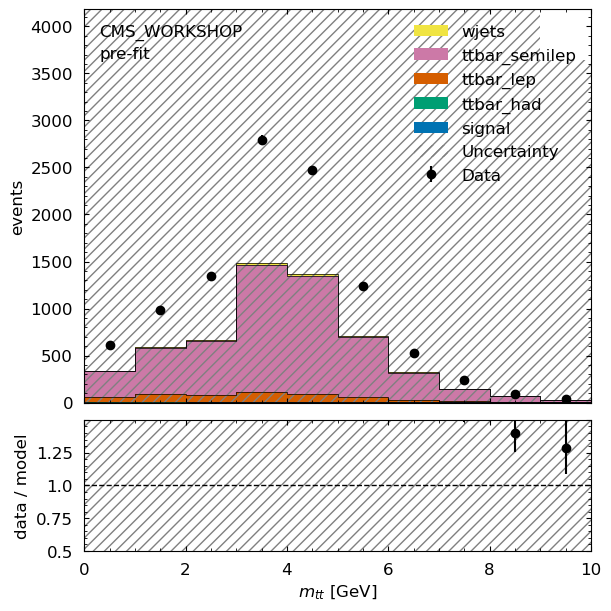

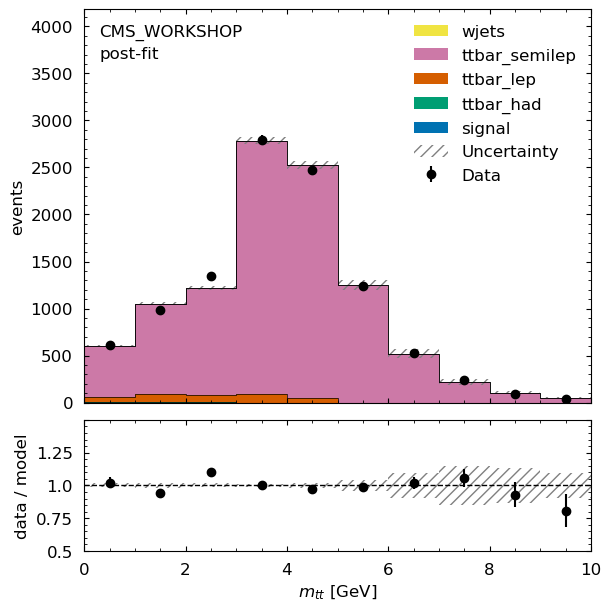

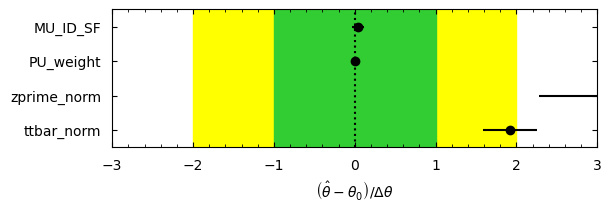

In [9]:
    # Step 4: Run Statistical Analysis
    if validated_config.general.run_statistics and output and "histograms" in output:
        print("\n📊 Running statistical analysis...")

        # Create analysis instance for statistics
        from intccms.analysis.nondiff import NonDiffAnalysis

        analysis = NonDiffAnalysis(validated_config, output_manager)
        # Set histograms from processor output
        analysis.nD_hists_per_region = output["histograms"]

        # Check if cabinetry config exists
        if hasattr(validated_config, 'statistics') and hasattr(validated_config.statistics, 'cabinetry_config'):
            cabinetry_config_path = validated_config.statistics.cabinetry_config

            # Check if file exists
            if Path(cabinetry_config_path).exists():
                print(f"✅ Using cabinetry config: {cabinetry_config_path}")
                analysis.run_statistics(cabinetry_config_path)
                print(f"✅ Statistical analysis complete!")
                print(f"📊 Plots saved to: {output_manager.statistics_dir}")
            else:
                print(f"⚠️  Cabinetry config not found: {cabinetry_config_path}")
                print(f"   Skipping statistics step")
        else:
            print(f"⚠️  No cabinetry_config specified in configuration")
            print(f"   Skipping statistics step")
    else:
        print("\n⚠️  Statistics step skipped (disabled or no histograms)")
